<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/handy_scripts/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

#Tensorflow DataSet

In [ ]:
# All dataset builders are subclass of tfds.core.DatasetBuilder. To get the list of available builders, uses tfds.list_builders()
tfds.list_builders()

## Load a dataset
The easiest way of loading a dataset is tfds.load. It will:

Download the data and save it as tfrecord files.
Load the tfrecord and create the tf.data.Dataset.

*By using **batch_size=-1**, you can load the **full dataset** in a single batch.*

In [7]:
from tensorflow.python.data.ops.dataset_ops import Dataset
ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)

In [8]:
print(ds)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


##Iterate over a dataset

####As dict </p>

By default, the tf.data.Dataset object contains a dict of tf.Tensors:

In [14]:
for example in ds.take(6):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  print(image.shape, label)

['image', 'label']
(240, 182, 3) tf.Tensor(1, shape=(), dtype=int64)
['image', 'label']
(266, 320, 3) tf.Tensor(2, shape=(), dtype=int64)
['image', 'label']
(200, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
['image', 'label']
(234, 240, 3) tf.Tensor(3, shape=(), dtype=int64)
['image', 'label']
(281, 500, 3) tf.Tensor(3, shape=(), dtype=int64)
['image', 'label']
(213, 320, 3) tf.Tensor(0, shape=(), dtype=int64)


In [18]:
expl1 = ds.take(1)  # Only take a single example

In [26]:
item = expl1.as_numpy_iterator().next()

2


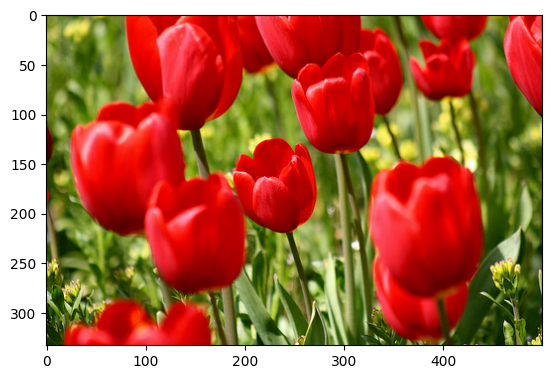

In [28]:
item = expl1.as_numpy_iterator().next()
print(item['label'])
plt.imshow(item['image'])

####As tuple

By using **as_supervised=True**, you can get a tuple (features, label) instead for supervised datasets.

In [29]:
ds = tfds.load('tf_flowers', split='train', shuffle_files=True, as_supervised=True)

2


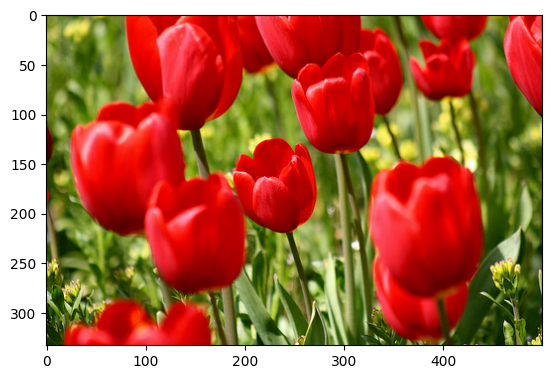

In [34]:
item_tuple = ds.take(1).as_numpy_iterator().next()
print(item_tuple[1])
plt.imshow(item_tuple[0])

In [36]:
for image, label in ds.take(6):
  print(f'shape of image {image.shape}')
  print(f'label is {label}')

shape of image (333, 500, 3)
label is 2
shape of image (212, 320, 3)
label is 3
shape of image (240, 320, 3)
label is 3
shape of image (240, 320, 3)
label is 4
shape of image (317, 500, 3)
label is 3
shape of image (212, 320, 3)
label is 0


### As numpy array

Uses tfds.as_numpy to convert:

tf.Tensor -> np.array
tf.data.Dataset -> Generator[np.array]


In [37]:
for image, label in tfds.as_numpy(ds.take(6)):
  print(type(image), type(label), label)

<class 'numpy.ndarray'> <class 'numpy.int64'> 1
<class 'numpy.ndarray'> <class 'numpy.int64'> 2
<class 'numpy.ndarray'> <class 'numpy.int64'> 3
<class 'numpy.ndarray'> <class 'numpy.int64'> 3
<class 'numpy.ndarray'> <class 'numpy.int64'> 4
<class 'numpy.ndarray'> <class 'numpy.int64'> 3


## Visualize a dataset and get info of dataset

Visualize datasets with tfds.show_examples (only image datasets supported now):

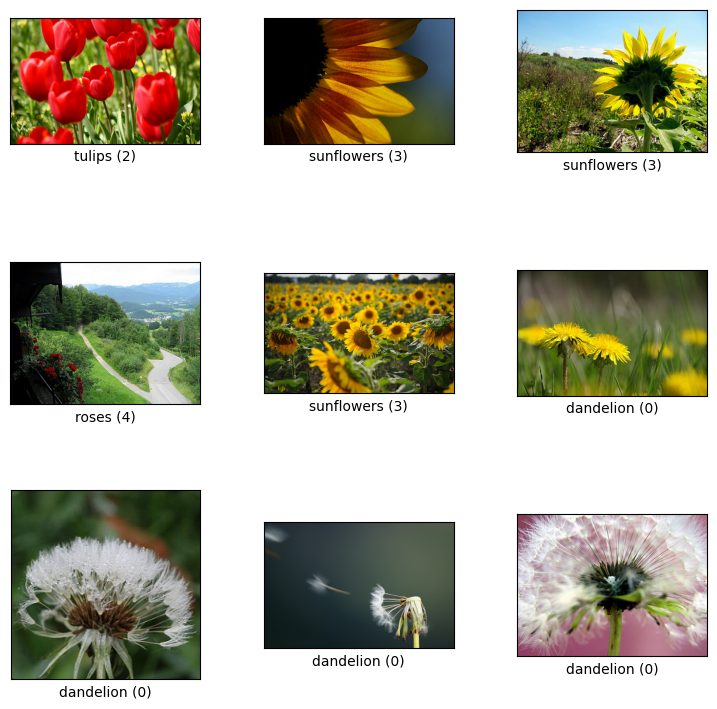

In [41]:
ds, info = tfds.load('tf_flowers', split = 'train', with_info=True)

fig = tfds.show_examples(ds, info)

In [42]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [43]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
})

In [44]:
info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [47]:
info.features['label'].num_classes

5

In [48]:
info.splits['train'].num_examples

3670

In [49]:
info.splits['test'].num_examples

ValueError: ignored

In [50]:
print(list(info.splits.keys()))

['train']


#Augmentation

In [91]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [52]:
metadata.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [53]:
metadata.features['label'].num_classes

5

In [54]:
get_label_name = metadata.features['label'].int2str

tulips


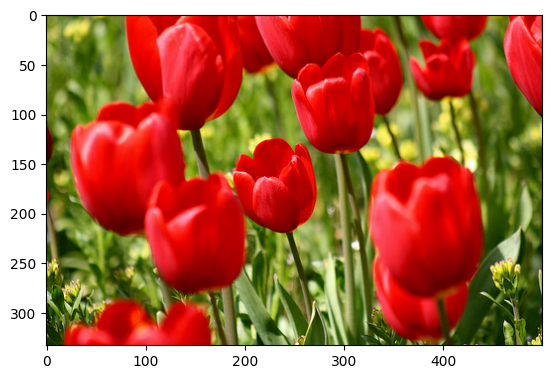

In [57]:
image, label = next(iter(train_ds.take(1)))
print(get_label_name(label))
plt.imshow(image)

## Use Keras preprocessing layers

### Resizing and rescaling

In [62]:
IMG_SIZE = 180

resize_rescale = tf.keras.models.Sequential((
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
))

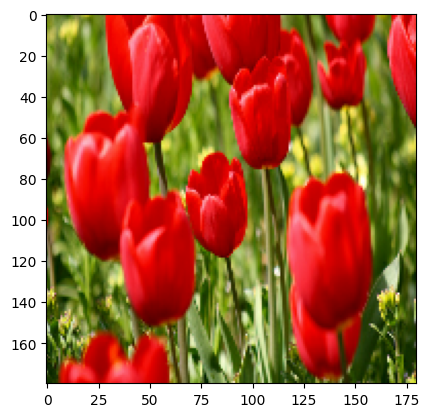

In [63]:
rezult = resize_rescale(image)
plt.imshow(rezult)

### Flip, Rotation

In [64]:
flip_rotation = tf.keras.models.Sequential((
    layers.RandomFlip(),
    layers.RandomRotation(0.3)
))

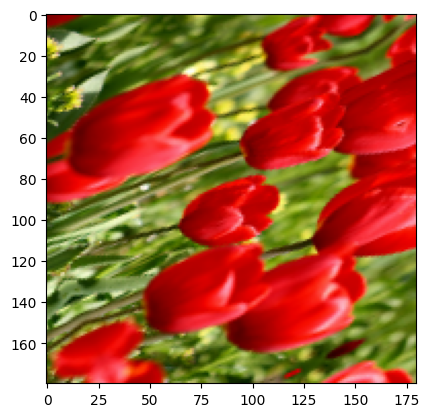

In [67]:
rezult = resize_rescale(image)
rezult = flip_rotation(rezult)
plt.imshow(rezult)

## Two options to use the Keras preprocessing layers
1. **Option 1: Make the preprocessing layers part of your model**

**Note**: Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).

2. **Option 2: Apply the preprocessing layers to your dataset**

In [69]:
# option 2
aug_ds = train_ds.map(
  lambda x, y: (resize_rescale(x, training=True), y))

### Build model using augmentation data

In [92]:
batch_size=32

AUTOTUNE = tf.data.AUTOTUNE

def prepare_data(ds, shuffle=False, augment = False):
  ds = ds.map(lambda x,y: (resize_rescale(x, training = True),y), num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds.shuffle(1000)
  if augment:
    ds.map(lambda x,y: (flip_rotation(x, training = True),y), num_parallel_calls=AUTOTUNE)
  # Batch all datasets.

  ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


In [93]:
train_ds = prepare_data(train_ds, shuffle=True, augment=True)
val_ds = prepare_data(val_ds)
test_ds = prepare_data(test_ds)

In [94]:
num_classes = metadata.features['label'].num_classes
num_classes

5

In [100]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

In [101]:
model.compile(optimizer='Adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics= ['accuracy'])

In [102]:
model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
92/92 [==============================] - 119s 1s/step - loss: 1.4520 - accuracy: 0.3811 - val_loss: 1.1641 - val_accuracy: 0.5368
Epoch 2/10
92/92 [==============================] - 115s 1s/step - loss: 1.0761 - accuracy: 0.5634 - val_loss: 1.0284 - val_accuracy: 0.6213
Epoch 3/10
92/92 [==============================] - 118s 1s/step - loss: 0.9223 - accuracy: 0.6475 - val_loss: 0.9865 - val_accuracy: 0.6403
Epoch 4/10
92/92 [==============================] - 121s 1s/step - loss: 0.7715 - accuracy: 0.7101 - val_loss: 0.9787 - val_accuracy: 0.6567
Epoch 5/10
92/92 [==============================] - 125s 1s/step - loss: 0.5665 - accuracy: 0.8007 - val_loss: 1.0861 - val_accuracy: 0.6131
Epoch 6/10
92/92 [==============================] - 142s 2s/step - loss: 0.4362 - accuracy: 0.8484 - val_loss: 1.1387 - val_accuracy: 0.6104
Epoch 7/10
92/92 [==============================] - 156s 2s/step - loss: 0.4048 - accuracy: 0.8556 - val_loss: 1.2664 - val_accuracy: 0.6049
Epoch 8/10
92

### Custom data augmentation

1. tf.keras.layers.Lambda.

2. new layer via subclassing




In [104]:
def random_invert_image(x, p = 0.7):
  if tf.random.uniform([]) < p:
    x = 255-x
  return x

In [105]:
def random_invert(factor = 0.7):
  return layers.Lambda(lambda x: random_invert_image(x, factor))



(-0.5, 499.5, 332.5, -0.5)

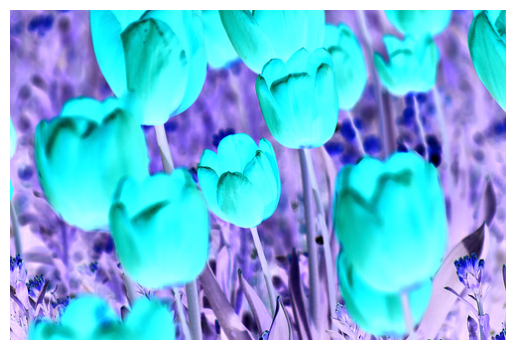

In [111]:
augmented_image = random_invert()(image)
plt.imshow(augmented_image)
plt.axis("off")

In [124]:
class RandomInvert(tf.keras.layers.Layer):
  def __init__(self, factor=0.4, **kwargs):
    super().__init__(**kwargs)
    self._factor = factor

  def call(self, x):
    return random_invert_image(x, self._factor)

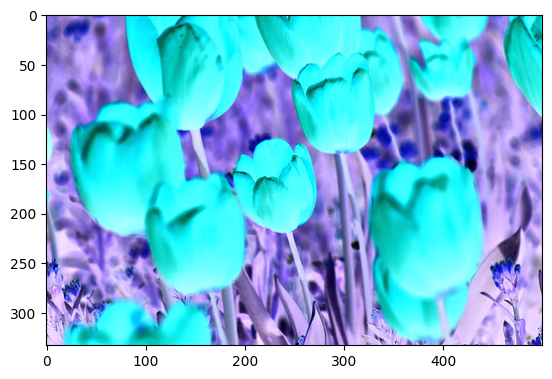

In [129]:
_ = plt.imshow(RandomInvert(0.7)(image))